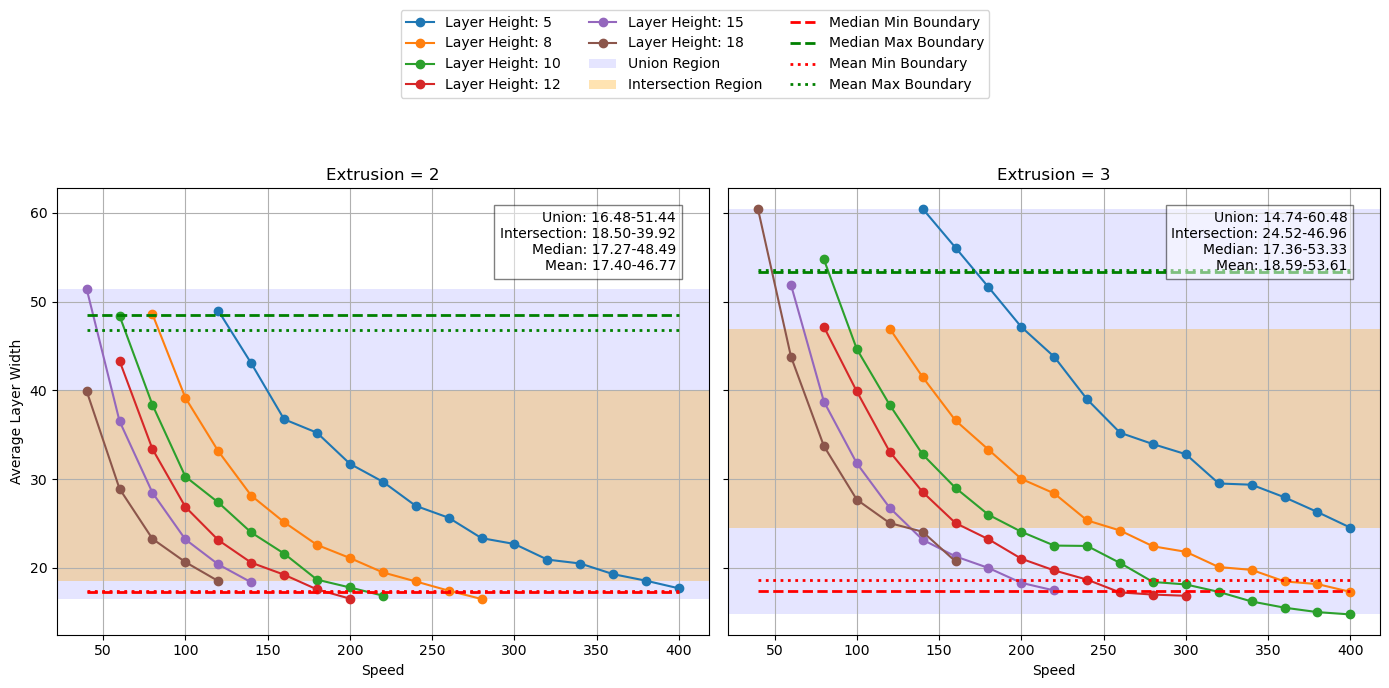

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read data from CSV file
df = pd.read_csv('data/data_3dcp_wClean.csv')

# Drop rows where layer_width == -1
df = df[df['layer_width'] != -1]

# Group by layer_height, extrusion, and speed to compute average layer_width
grouped = df.groupby(['layer_height', 'extrusion', 'speed'], as_index=False)['layer_width'].mean()

# Set up subplots for extrusion = 2 (left) and extrusion = 3 (right)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Process each extrusion value
for i, extr in enumerate([2, 3]):
    ax = axes[i]
    sub_data = grouped[grouped['extrusion'] == extr]
    
    if sub_data.empty:
        ax.text(0.5, 0.5, f"No data for extrusion {extr}",
                horizontalalignment='center', verticalalignment='center')
    else:
        boundary_list = []
        
        # Plot the average layer_width vs. speed for each layer_height and record boundaries
        for layer_height, group in sub_data.groupby('layer_height'):
            ax.plot(group['speed'], group['layer_width'], marker='o',
                    label=f"Layer Height: {layer_height}")
            min_val = group['layer_width'].min()
            max_val = group['layer_width'].max()
            boundary_list.append((min_val, max_val))
        
        # Calculate union boundaries (the envelope across all layer_heights)
        union_min = min(b[0] for b in boundary_list)
        union_max = max(b[1] for b in boundary_list)
        
        # Calculate intersection boundaries (the overlap common to all layer_heights)
        intersect_min = max(b[0] for b in boundary_list)
        intersect_max = min(b[1] for b in boundary_list)
        
        # Determine the overall speed range for this extrusion group
        speed_min = sub_data['speed'].min()
        speed_max = sub_data['speed'].max()
        
        # Highlight the union region (light blue) and intersection region (light orange)
        ax.axhspan(union_min, union_max, facecolor='blue', alpha=0.1, label='Union Region')
        if intersect_min < intersect_max:
            ax.axhspan(intersect_min, intersect_max, facecolor='orange', alpha=0.3, label='Intersection Region')
        else:
            ax.text(0.5, 0.5, "No intersection region", transform=ax.transAxes, ha='center')
        
        # Compute medial (median) boundaries across layer heights
        med_min = np.median([b[0] for b in boundary_list])
        med_max = np.median([b[1] for b in boundary_list])
        # Draw the median boundaries as dashed lines
        ax.hlines(med_min, speed_min, speed_max, colors='red', linestyles='dashed',
                  linewidth=2, label='Median Min Boundary')
        ax.hlines(med_max, speed_min, speed_max, colors='green', linestyles='dashed',
                  linewidth=2, label='Median Max Boundary')
        
        # Compute mean boundaries across layer heights
        mean_min = np.mean([b[0] for b in boundary_list])
        mean_max = np.mean([b[1] for b in boundary_list])
        # Draw the mean boundaries as dotted lines
        ax.hlines(mean_min, speed_min, speed_max, colors='red', linestyles='dotted',
                  linewidth=2, label='Mean Min Boundary')
        ax.hlines(mean_max, speed_min, speed_max, colors='green', linestyles='dotted',
                  linewidth=2, label='Mean Max Boundary')
        
        # Annotate the boundaries in the top right of the subplot
        annotation_text = (f"Union: {union_min:.2f}-{union_max:.2f}\n"
                           f"Intersection: {intersect_min:.2f}-{intersect_max:.2f}\n"
                           f"Median: {med_min:.2f}-{med_max:.2f}\n"
                           f"Mean: {mean_min:.2f}-{mean_max:.2f}")
        ax.text(0.95, 0.95, annotation_text, transform=ax.transAxes,
                ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))
    
    ax.set_title(f"Extrusion = {extr}")
    ax.set_xlabel("Speed")
    if i == 0:
        ax.set_ylabel("Average Layer Width")
    ax.grid(True)

# Create a single common legend from both subplots.
handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)

# Position the legend higher up (using bbox_to_anchor)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()